## Benchmark Lorenz 63 linear and nonlinear filters

In this notebook, we are interested in the sequential inference 



References: 


[1] Evensen, G., 1994. Sequential data assimilation with a nonlinear quasi‐geostrophic model using Monte Carlo methods to forecast error statistics. Journal of Geophysical Research: Oceans, 99(C5), pp.10143-10162.

[2] Asch, M., Bocquet, M. and Nodet, M., 2016. Data assimilation: methods, algorithms, and applications. Society for Industrial and Applied Mathematics.

[3] Bishop, C.H., Etherton, B.J. and Majumdar, S.J., 2001. Adaptive sampling with the ensemble transform Kalman filter. Part I: Theoretical aspects. Monthly weather review, 129(3), pp.420-436. 

[4] Lorenz, E.N., 1963. Deterministic nonperiodic flow. Journal of atmospheric sciences, 20(2), pp.130-141.

[5] Spantini, A., Baptista, R. and Marzouk, Y., 2019. Coupling techniques for nonlinear ensemble filtering. arXiv preprint arXiv:1907.00389.

### The basic steps
To carry out sequential inference in `AdaptiveTransportMap`, we need to carry out a few basic steps:
* **Specify the problem**: Define the state-space model: initial condition, dynamical and observation models (including process and observation noise)
* **Specify the inflation parameters**: Determine the levels of covariance inflation to properly balance the dynamical system and the observations from the truth system
* **Specify the filter**: Choose the ensemble filter to assimilate the observations in the state estimate
* **Perform the sequential inference**: Perform the sequential inference

We will go through all of these here.

In [1]:
using Revise
using LinearAlgebra
using AdaptiveTransportMap
using Statistics
using Distributions
using OrdinaryDiffEq
using JLD

┌ Info: Precompiling AdaptiveTransportMap [bdf749b0-1400-4207-80d3-e689c0e3f03d]
└ @ Base loading.jl:1278
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been

In [2]:
using DelimitedFiles

Load some packages to make nice figures

In [3]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
# Plots.font("sans-serif")
# clibrary(:colorbrewer)
# gr()
pyplot()

using LaTeXStrings
# PyPlot.rc("text", usetex = "true")
# rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
# rcParams["text.usetex"] = true;
PyPlot.rc("font", family = "CMU Serif")
PyPlot.matplotlib[:rc]("mathtext",fontset="cm")        #computer modern font 
PyPlot.matplotlib[:rc]("font",family="serif",size=12)

using ColorSchemes

In [40]:
# clibrary(:colorbrewer)
default(clim = (-0.05, 0.05), markerstrokealpha = 0, markersize = 6, grid = false, xtickfontsize = 12, 
    legendfontsize = 12,
    ytickfontsize = 12,
     legend = true, colorbar = :right)

c_enkf = colorant"chartreuse3" 
c_smap0 = RGB(0.686,0.624,0.11)
c_smap1 = colorant"Steel Blue"
c_smap2 = colorant"dark red"
# c_AvgMR = colorant"orange"

cl = (c_enkf, c_smap0, c_smap1, c_smap2)

for c in cl 
    convert(RGBA,c)
    @show parse(RGBA, c);
end

parse(RGBA, c) = RGB{N0f8}(0.4,0.804,0.0)
parse(RGBA, c) = RGB{Float64}(0.686,0.624,0.11)
parse(RGBA, c) = RGB{N0f8}(0.275,0.51,0.706)
parse(RGBA, c) = RGB{N0f8}(0.545,0.0,0.0)


The Lorenz-63  model is a three dimensional system that models the atmospheric convection [4]. This system is a classical benchmark problem in data assimilation. The state $\boldsymbol{x} = (x_1, x_2, x_3)$ is governed by the following set of ordinary differential equations:

\begin{equation}
\begin{aligned}
&\frac{\mathrm{d} x_1}{\mathrm{d} t}=\sigma(x_2-x_1)\\
&\frac{\mathrm{d} x_2}{\mathrm{d} t}=x_1(\rho-x_2)-x_2\\
&\frac{\mathrm{d} x_3}{\mathrm{d} t}=x_1 x_2-\beta x_3,
\end{aligned}
\end{equation}

where $\sigma = 10, \beta = 8/3, \rho = 28$. For these values, the system is chaotic and behaves like a strange attractor. We integrate this system of ODEs with time step $\Delta t_{dyn} = 0.05$. The state is fully observed $h(t,\boldsymbol{x}) = \boldsymbol{x}$ with $\Delta t_{obs}=0.1$. The initial distribution $\pi_{\mathsf{X}_0}$ is the standard Gaussian. The process noise is Gaussian with zero mean and covariance $10^{-4}\boldsymbol{I}_3$. The measurement noise has a Gaussian distribution with zero mean and covariance $\theta^2\boldsymbol{I}_3$ where $\theta^2 = 4.0$.

In [4]:
path = "/media/mat/HDD/AdaptiveTransportMap/notebooks/lorenz63/data/"

β_array = collect(0.95:0.01:1.05)
Ne_array = [10, 20, 40, 60, 100, 200, 400, 600]

8-element Array{Int64,1}:
  10
  20
  40
  60
 100
 200
 400
 600

In [15]:
metric_enkf = load(path*"metric_enkf.jld", "metric")

8-element Array{Any,1}:
 Metrics[Metrics(10, [0.5501155423655157, 0.4552174161501478, 0.30716513784836674, 0.10038774669799577, 0.08218080049634328, 0.19864307927600722, 0.1824673472635377, 0.3487293662557289, 0.25157243271863766, 0.34927333990261134  …  0.5251535219198199, 0.5130321306056926, 0.4087223781331781, 0.42970319856574385, 0.7575559865817667, 1.0782501215740468, 0.9689270377325875, 0.8880960798966999, 0.671218044293725, 0.4918223353312043], 0.43712938291689063, 0.6663970586950805, 0.7231929358627925, [0.41664027365273104, 0.47536366688100923, 0.44458709001921204, 0.3673356950026079, 0.25972920619952233, 0.2987015727881913, 0.3883029371321134, 0.5419937497644906, 0.3143408348220382, 0.27087853345073926  …  0.4929207567401795, 0.40103903832959226, 0.28112436783535716, 0.25697139764041427, 0.32429643135256736, 0.36308386121401987, 0.3638751540515188, 0.2933893674101825, 0.26103792530394865, 0.21386890766308456], 0.4169513824084894, 0.4905758592570392, 0.26314899670487335, [1.0,

In [24]:
rmse_enkf = zeros(length(metric_enkf))
covprob_enkf = zeros(length(metric_enkf))
Ne_enkf = zeros(Int64, length(metric_enkf))
for (i, metrics) in enumerate(metric_enkf)
    rmse_enkf[i] = minimum([metrics[j].rmse_mean for j=1:length(metrics)])
    covprob_enkf[i] = maximum([metrics[j].covprob_mean for j=1:length(metrics)])
    Ne_enkf[i] = metrics[1].Ne
end

Nonlinear filter

In [7]:
p = 0
metric_srmf0 = load(path*"metric_srmf"*string(p)*".jld", "metric")

8-element Array{Any,1}:
 Metrics[Metrics(10, [0.29497157220509546, 0.26103397333464035, 0.06758302728329897, 0.8727500358667812, 0.7014920806454852, 0.816007829546341, 1.3084193856129032, 1.731808828543137, 0.971141072856048, 1.1686845313954584  …  1.1130873974512208, 0.9732228307414715, 0.7154158374619614, 0.6745848080542884, 1.0946404931041749, 1.226834286366876, 1.031014840624962, 0.7480263924993406, 0.7815114672132842, 0.6217835128675873], 0.6512839566154017, 1.1484494268122272, 1.977160276359985, [1.1490470875802228, 0.8006897580998372, 0.7131561734681872, 0.669071483439615, 0.4576121806411383, 0.34932454316885503, 0.5780807866800096, 0.7232004974646553, 0.6405982830447237, 0.3956846291734676  …  0.766891334170219, 0.5405797959657936, 0.48953914291988837, 0.4772365192419163, 0.7214814788920553, 0.6053348466791195, 0.5035941084640811, 0.456932533762776, 0.41618831667030637, 0.46099484852926026], 0.6216338427364627, 0.6767659220102428, 0.28869277938197535, [1.0, 1.0, 1.0, 0.33333333

In [26]:
rmse_srmf0 = zeros(length(metric_srmf0))
covprob_srmf0 = zeros(length(metric_srmf0))
Ne_srmf0 = zeros(Int64, length(metric_srmf0))
for (i, metrics) in enumerate(metric_srmf0)
    rmse_srmf0[i] = minimum([metrics[j].rmse_mean for j=1:length(metrics)])
    covprob_srmf0[i] = maximum([metrics[j].covprob_mean for j=1:length(metrics)])
    Ne_srmf0[i] = metrics[1].Ne
end

In [8]:
p = 1
metric_srmf1 = load(path*"metric_srmf"*string(p)*".jld", "metric")

6-element Array{Any,1}:
 Metrics[Metrics(40, [1.680339066081632, 1.4826451290753746, 1.2957926257042371, 0.9278133372902646, 0.6149230743841606, 0.442523886519581, 0.5051346644383523, 0.40692063373581905, 0.4770607011962181, 0.79029142115327  …  0.44350217471372017, 0.3935435975111943, 0.2521080372932962, 0.29018588722769795, 0.8186582534212197, 0.8551971957740322, 0.6100501981839419, 0.6793146782650545, 0.5186593925859703, 0.49923401319460164], 0.4497387060565178, 0.7723808130054851, 1.3343555456094915, [0.4932019068031731, 0.4635758583046814, 0.38727909008201766, 0.2773224839547451, 0.28921443752381815, 0.4061069260166923, 0.6247324311193191, 0.7293908176968098, 0.6187752371028863, 0.3322514014521542  …  0.6333223292030578, 0.5542178008224228, 0.48462547709563797, 0.48426881134244615, 0.6611174985660866, 1.0015244383944504, 0.6423186978130242, 0.5136157873657978, 0.42981343531590294, 0.36837150782906275], 0.5252604540366821, 0.5851570053271286, 0.26262746743560467, [0.0, 0.3333333333

In [28]:
rmse_srmf1 = zeros(length(metric_srmf1))
covprob_srmf1 = zeros(length(metric_srmf1))
Ne_srmf1 = zeros(Int64, length(metric_srmf1))
for (i, metrics) in enumerate(metric_srmf1)
    rmse_srmf1[i] = minimum([metrics[j].rmse_mean for j=1:length(metrics)])
    covprob_srmf1[i] = maximum([metrics[j].covprob_mean for j=1:length(metrics)])
    Ne_srmf1[i] = metrics[1].Ne
end

In [29]:
p = 2
metric_srmf2 = load(path*"metric_srmf"*string(p)*".jld", "metric")

5-element Array{Any,1}:
 Metrics[Metrics(60, [1.1212275951577777, 0.9894399175032134, 0.6773533653501694, 0.12172562387609412, 0.3705419505069346, 0.2823822317957321, 0.49403607972016506, 0.44574140545736424, 0.4052424207118385, 0.3635557840634013  …  4.498759594554579, 2.9551830546398046, 2.253879839350973, 1.4860601751903288, 1.6153465647246756, 1.4054025483888022, 1.398643041682247, 1.3309307989536625, 1.171566108043959, 1.3261431913196509], 0.46138776053793207, 0.762719711537487, 1.3385036438927826, [0.7107422067305945, 0.6402421538552566, 0.5175939281593656, 0.2991399877694167, 0.3174943179794381, 0.3870642646022849, 0.5331748200181484, 0.5671536645393727, 0.568066025472932, 0.48271013872201035  …  0.415981138546738, 0.508187608973518, 0.5036812569223404, 0.35973298554116817, 0.40113813276976285, 0.46698178143663327, 0.5178767543534228, 0.4243381290519647, 0.39669321656339673, 0.3578157504900627], 0.5364556895115233, 0.5906591657500058, 0.2568779972041202, [1.0, 0.6666666666666666

In [30]:
rmse_srmf2 = zeros(length(metric_srmf2))
covprob_srmf2 = zeros(length(metric_srmf2))
Ne_srmf2 = zeros(Int64, length(metric_srmf2))
for (i, metrics) in enumerate(metric_srmf2)
    rmse_srmf2[i] = minimum([metrics[j].rmse_mean for j=1:length(metrics)])
    covprob_srmf2[i] = maximum([metrics[j].covprob_mean for j=1:length(metrics)])
    Ne_srmf2[i] = metrics[1].Ne
end

Adaptive nonlinear filter

In [10]:
p = 0
metric_sadaptivermf0 = load(path*"metric_sadaptivermf0"*string(p)*".jld", "metric")

8-element Array{Any,1}:
 Metrics[Metrics(10, [0.26561014400200944, 1.0873956577137724, 1.7836075137937701, 2.2820962730947216, 1.0756557067996297, 1.0766682110216386, 0.8701757765428049, 0.8320774049000857, 1.299672938517753, 1.4454929289174094  …  1.0762395595458523, 0.7672012844483375, 0.9069413930004709, 0.9761750058213498, 1.832281184391516, 1.4303375288615108, 1.146506605092065, 0.7510822552247277, 1.0023932056226899, 0.8943119856962052], 0.8114726251856159, 0.9566654682239755, 0.6838475592713943, [1.9235878364127321, 1.3628370228532853, 0.8871756652983396, 0.6171538159165771, 0.5674692710732154, 0.5745716599690718, 0.8810459332626378, 0.7318780604650924, 0.5858233358806202, 0.5205480025698502  …  0.8093515394682365, 0.7103800034563412, 0.6039164221386101, 0.7831107099216037, 0.7652401723424034, 0.86153646607946, 0.6568451559602245, 0.7845990632459072, 0.9777409474569942, 0.8828176754339785], 0.7223844285476746, 0.7632614460563157, 0.28237588422014814, [1.0, 1.0, 0.0, 0.0, 0.33333

In [31]:
rmse_sadaptivermf0 = zeros(length(metric_sadaptivermf0))
covprob_sadaptivermf0 = zeros(length(metric_sadaptivermf0))
Ne_sadaptivermf0 = zeros(Int64, length(metric_sadaptivermf0))
for (i, metrics) in enumerate(metric_sadaptivermf0)
    rmse_sadaptivermf0[i] = minimum([metrics[j].rmse_mean for j=1:length(metrics)])
    covprob_sadaptivermf0[i] = maximum([metrics[j].covprob_mean for j=1:length(metrics)])
    Ne_sadaptivermf0[i] = metrics[1].Ne
end

In [12]:
p = 1
metric_sadaptivermf1 = load(path*"metric_sadaptivermf1"*string(p)*".jld", "metric")

6-element Array{Any,1}:
 Metrics[Metrics(40, [1.1663052681805817, 1.137714953511157, 1.0054155093189059, 0.534974003791907, 0.28757192520916114, 0.38963784165682247, 0.6127188224971838, 0.546609504244255, 0.5154325858061669, 0.12012484544742065  …  0.43706820802071955, 0.1817395361265907, 0.09493654746012888, 0.06119832979600937, 0.41573279533471774, 0.4822997106817081, 0.47609136197828655, 0.6174071852972727, 0.30971649770204723, 0.435171380196354], 0.45594669963985623, 0.5816500372451683, 0.4422507038854142, [0.6468257967163894, 0.6825427549073632, 0.5351265411239169, 0.4291831048102853, 0.3539906184830342, 0.4311977824107651, 0.5788766347275786, 0.6737644079738515, 0.6084451925250448, 0.48227858452965355  …  0.5302268477072609, 0.5223755413326986, 0.44520958491501694, 0.509313623728455, 0.6684052042214843, 0.8044261656064084, 0.7099601656238347, 0.6142313900031734, 0.5274832288523414, 0.49958904440379875], 0.6018496878658672, 0.6474698392644976, 0.24359776694512456, [0.3333333333333

In [32]:
rmse_sadaptivermf1 = zeros(length(metric_sadaptivermf1))
covprob_sadaptivermf1 = zeros(length(metric_sadaptivermf1))
Ne_sadaptivermf1 = zeros(Int64, length(metric_sadaptivermf1))
for (i, metrics) in enumerate(metric_sadaptivermf1)
    rmse_sadaptivermf1[i] = minimum([metrics[j].rmse_mean for j=1:length(metrics)])
    covprob_sadaptivermf1[i] = maximum([metrics[j].covprob_mean for j=1:length(metrics)])
    Ne_sadaptivermf1[i] = metrics[1].Ne
end

In [13]:
p = 2
metric_sadaptivermf2 = load(path*"metric_sadaptivermf2"*string(p)*".jld", "metric")

5-element Array{Any,1}:
 Metrics[Metrics(60, [0.9729062617026304, 0.7086332959151473, 0.534659926604121, 0.14731400246704704, 0.1996218812266719, 0.5551808455449547, 0.2074589586649262, 0.3028397459168981, 0.17285768280397645, 0.1598063668597117  …  1.3303766925779352, 1.0760874634109268, 1.213266187290864, 1.110303500297021, 1.7074645433843332, 2.10599745223709, 1.6771208385702359, 1.519744372518816, 0.9442739263891504, 0.6772918283141144], 0.5632384039683438, 0.7590563412868957, 0.9627894311039932, [0.8640522150156568, 0.711258237865409, 0.6621136679476056, 0.5606039224464167, 0.6152101694937371, 0.6262462245539885, 0.8211160946637818, 0.8193456243037817, 0.5965863464475745, 0.5607696701008604  …  0.7984312819839371, 0.6465235286478972, 0.6998047104451097, 0.5902065125614024, 0.6835509131297336, 0.601446750998765, 0.5964090862691839, 0.5808310728919144, 0.4735532232201908, 0.5700709150682484], 0.6739527878054972, 0.7140598535679314, 0.2621471122074318, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

In [33]:
rmse_sadaptivermf2 = zeros(length(metric_sadaptivermf2))
covprob_sadaptivermf2 = zeros(length(metric_sadaptivermf2))
Ne_sadaptivermf2 = zeros(Int64, length(metric_sadaptivermf2))
for (i, metrics) in enumerate(metric_sadaptivermf2)
    rmse_sadaptivermf2[i] = minimum([metrics[j].rmse_mean for j=1:length(metrics)])
    covprob_sadaptivermf2[i] = maximum([metrics[j].covprob_mean for j=1:length(metrics)])
    Ne_sadaptivermf2[i] = metrics[1].Ne
end

## Plot RMSE

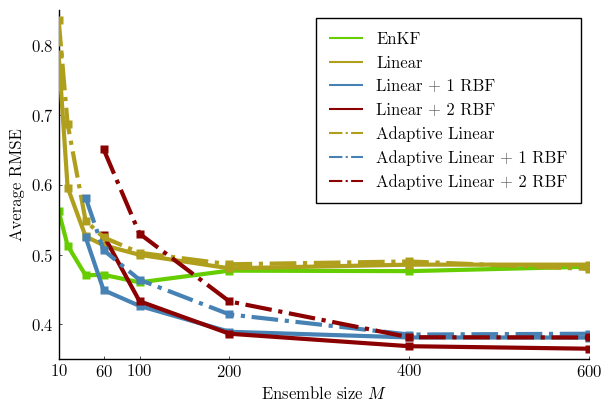

In [76]:
plot(Ne_enkf, rmse_enkf, label = "EnKF", color = c_enkf, linewidth = 3, grid = false, xlims = (-Inf, Inf), 
     xticks = [10, 60, 100, 200, 400, 600],
    xlabel = "Ensemble size "*latexstring("M"), ylabel = "Average RMSE")
scatter!(Ne_enkf, rmse_enkf, color = c_enkf, label = "", markershape = :square)#, fg_legend = :transparent)
# Nonlinear one
plot!(Ne_srmf0, rmse_srmf0, color = c_smap0, label = "Linear", linewidth = 3)
scatter!(Ne_srmf0, rmse_srmf0, color = c_smap0, label = "", markershape = :square )
plot!(Ne_srmf1, rmse_srmf1, color = c_smap1, label = "Linear + 1 RBF", linewidth = 3)
scatter!(Ne_srmf1, rmse_srmf1, color = c_smap1, label = "", markershape = :square )
plot!(Ne_srmf2, rmse_srmf2, color = c_smap2, label = "Linear + 2 RBF", linewidth = 3)
scatter!(Ne_srmf2, rmse_srmf2, color = c_smap2, label = "", markershape = :square)
# Adaptive
plot!(Ne_sadaptivermf0, rmse_sadaptivermf0, color = c_smap0, label = "Adaptive Linear", linestyle = :dashdot, linewidth = 3)
scatter!(Ne_sadaptivermf0, rmse_sadaptivermf0, color = c_smap0, label = "", markershape = :square )
plot!(Ne_sadaptivermf1, rmse_sadaptivermf1, color = c_smap1, label = "Adaptive Linear + 1 RBF", linestyle = :dashdot, linewidth = 3)
scatter!(Ne_sadaptivermf1, rmse_sadaptivermf1, color = c_smap1, label = "", markershape = :square )
plot!(Ne_sadaptivermf2, rmse_sadaptivermf2, color = c_smap2, label = "Adaptive Linear + 2 RBF", linestyle = :dashdot, linewidth = 3)
scatter!(Ne_sadaptivermf2, rmse_sadaptivermf2, color = c_smap2, label = "", markershape = :square)

savefig(path*"rmse_lorenz63.pdf")

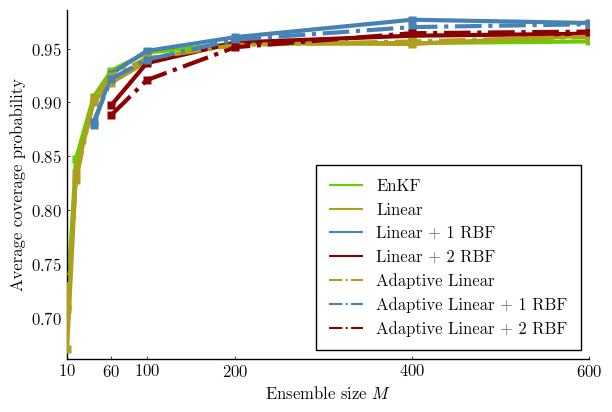

In [73]:
plot(Ne_enkf, covprob_enkf, label = "EnKF", color = c_enkf, linewidth = 3, grid = false, xlims = (-Inf, Inf), 
     xticks = [10, 60, 100, 200, 400, 600],
    xlabel = "Ensemble size "*latexstring("M"), ylabel = "Average coverage probability", legend = :bottomright)
scatter!(Ne_enkf, covprob_enkf, color = c_enkf, label = "", markershape = :square)#, fg_legend = :transparent)
# Nonlinear one
plot!(Ne_srmf0, covprob_srmf0, color = c_smap0, label = "Linear", linewidth = 3)
scatter!(Ne_srmf0, covprob_srmf0, color = c_smap0, label = "", markershape = :square )
plot!(Ne_srmf1, covprob_srmf1, color = c_smap1, label = "Linear + 1 RBF", linewidth = 3)
scatter!(Ne_srmf1, covprob_srmf1, color = c_smap1, label = "", markershape = :square )
plot!(Ne_srmf2, covprob_srmf2, color = c_smap2, label = "Linear + 2 RBF", linewidth = 3)
scatter!(Ne_srmf2, covprob_srmf2, color = c_smap2, label = "", markershape = :square)
# Adaptive
plot!(Ne_sadaptivermf0, covprob_sadaptivermf0, color = c_smap0, label = "Adaptive Linear", linestyle = :dashdot, linewidth = 3)
scatter!(Ne_sadaptivermf0, covprob_sadaptivermf0, color = c_smap0, label = "", markershape = :square )
plot!(Ne_sadaptivermf1, covprob_sadaptivermf1, color = c_smap1, label = "Adaptive Linear + 1 RBF", linestyle = :dashdot, linewidth = 3)
scatter!(Ne_sadaptivermf1, covprob_sadaptivermf1, color = c_smap1, label = "", markershape = :square )
plot!(Ne_sadaptivermf2, covprob_sadaptivermf2, color = c_smap2, label = "Adaptive Linear + 2 RBF", linestyle = :dashdot, linewidth = 3)
scatter!(Ne_sadaptivermf2, covprob_sadaptivermf2, color = c_smap2, label = "", markershape = :square)

savefig(path*"covprob_lorenz63.pdf")